# IMPORTS

In [1]:
import os, sys, git, time, io, ntpath, tracemalloc, sqlite3, pandas as pd, numpy as np
from pandas.api.types import CategoricalDtype
import sklearn
from scripts.log_processing.plotting import *

from scripts.log_processing.mazeAndPcsPlotter import *
import xml.etree.ElementTree as ET


# DO NOT IMPORT IN REAL SCRIPT:
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display
from os import path
import matplotlib.collections
import matplotlib.collections as mcoll
import matplotlib.path as mpath

%matplotlib widget

# DEFAULT PLOTTING THEMES

In [2]:
theme_default = theme (
    plot_title = element_text(size = 17),
    axis_title = element_text(size = 17),
    legend_title = element_text(size = 17),
    legend_text = element_text(size = 12)
)
theme_set(theme_default)

# Functions

In [3]:
def adapt_array(arr):
    out = io.BytesIO()
    np.save(out, arr)
    out.seek(0)
    return sqlite3.Binary(out.read())

def convert_array(text):
    out = io.BytesIO(text)
    out.seek(0)
    return np.load(out)

# Converts np.array to TEXT when inserting
sqlite3.register_adapter(np.ndarray, adapt_array)

# Converts TEXT to np.array when selecting
sqlite3.register_converter("array", convert_array)

def lastEpisode(configs, sample_rate):
    num_episodes = configs['numEpisodes'].max() / configs['numStartingPositions'].max()
    last_episode = -sample_rate % num_episodes
    return last_episode

def getDataEpisodeAndSummaries(db, configs, fields_to_add, episode, location, skip_runtimes = False, skip_summary = False):
    # GET INDICES TO BE RETRIEVED AND EXTRA DATA TO BE MERGED
    indices = [np.uint16(c[1:]) for c in configs.index]  # config numbers
    
    # GET SUMMARIZED RUNTIME DATA
    summaries = None if skip_summary else augment_data(load_summaries(db, indices, location)[0], configs, fields_to_add)

    # GET EPISODE DATA:
    runtimes_episode = None if skip_runtimes else augment_data(load_episode_runtimes(db, indices, location, episode), configs, fields_to_add)
            
    return summaries, runtimes_episode

def getReplayData(db, configs, fields_to_add, episode, location, skip_runtimes = False, skip_summary = False):
    # GET INDICES TO BE RETRIEVED AND EXTRA DATA TO BE MERGED
    indices = [np.uint16(c[1:]) for c in configs.index]  # config numbers
    
    # GET Replay DATA
    summaries = None if skip_summary else augment_data(load_summaries(db, indices, location)[1], configs, fields_to_add)
            
    return summaries

def getFirstReplayData(db, configs, fields_to_add, episode, location, skip_runtimes = False, skip_summary = False):
    # GET INDICES TO BE RETRIEVED AND EXTRA DATA TO BE MERGED
    indices = [np.uint16(c[1:]) for c in configs.index]  # config numbers
    
    # GET Replay DATA
    summaries = None if skip_summary else augment_data(load_summaries(db, indices, location)[2], configs, fields_to_add)
            
    return summaries

def getLearningTimes(db, configs, location, threshold, fields_to_add):
    indices = [np.uint16(c[1:]) for c in configs.index]  # config numbers
    
    runtimes_all_episodes = load_all_runtimes_smaller_than_threshold(db, indices, location, threshold)  
    
    # learning rat defined as min episode with error < threshold
    learning_times = runtimes_all_episodes.loc[runtimes_all_episodes.groupby(['config', 'location', 'rat'])['episode'].idxmin()]
    
    return augment_data(learning_times, configs, fields_to_add)

def getTotalLearningTimes(db, configs, location, threshold, fields_to_add):
    indices = [np.uint16(c[1:]) for c in configs.index]  # config numbers
    
    runtimes_all_episodes = load_episode_runtimes2(db, indices, location)
    
    # learning rat defined as min episode with error < threshold
    learning_times = runtimes_all_episodes.loc[runtimes_all_episodes.groupby(['config', 'location', 'rat'])['episode'].idxmin()]
    
    return augment_data(learning_times, configs, fields_to_add)

def augment_data(data, configs, fields):
    return pd.merge(data, configs[ ['c_id'] + fields ], left_on='config', right_on='c_id', how='left')

def addCatigoricalData(data, field):
    catigorical_name = field + '_c'
    data[catigorical_name] = data[field].astype(CategoricalDtype(data[field].unique(), ordered=True))

def load_summaries(db, config_indices, location):
    indices_str = ','.join(map(str, config_indices))
    df = pd.read_sql_query("select config, location, rat, episode, errors as steps "
                           "from rat_runtimes "
                           "where config in ({}) "
                           "AND location = {}"
                           .format(indices_str, np.uint8(location)), db)
    df2 = pd.read_sql_query("select config, rat, replay_matrix, mean, std, total_connection "
                           "from rat_replay_matrix "
                           "where config in ({}) "
                           .format(indices_str, np.uint8(location)), db)
    df3 = pd.read_sql_query("select config, rat, first_replay_matrix  "
                           "from rat_first_replay_matrix "
                           "where config in ({}) "
                           .format(indices_str, np.uint8(location)), db)
    # adjust data types to reduce memory size
    df.config = df.config.astype(np.uint16)
    df.location = df.location.astype(np.uint8)
    df.episode = df.episode.astype(np.uint16)
    df.steps = df.steps.astype(np.float32)
    return [df, df2, df3]
    

# SET EXPERIMENT AND LOAD DATABASE

In [4]:
folder = 'experiments/replayF2021_experiments/logs/experiment13-unseenPaths/'
figure_folder = folder + 'figures/'
make_folder(figure_folder)

git_root = './'

layers_folder = 'experiments/pc_layers/'
layer_metrics_file = os.path.join(git_root, layers_folder + 'layer_metrics.csv')

maze_folder = 'experiments/mazes/'
maze_metrics_file = os.path.join(git_root, maze_folder + 'mazeMetrics.csv')

unseen_path_folder = 'experiments/unseen_paths/'

sample_rate = 1
db = sqlite3.connect(folder + 'experiment_results.sqlite',detect_types=sqlite3.PARSE_DECLTYPES)


In [5]:
min_layers = ['u04_40', 'u08_21', 'u12_14', 'u16_11', 'u20_09', 'u24_07', 'u28_06', 'u32_06', 'u36_06', 'u40_05', 'u44_05', 'u48_04', 'u52_04', 'u56_04']

# ADD COLUMNS TO CONFIGS
configs = load_config_file(folder)
configs['c_id'] = configs.index.map(lambda v : int(v[1:]))
configs['pc_files'] = configs.pc_files.map(os.path.normpath )
configs['pcs'] = configs.pc_files.map(lambda v : ntpath.basename(v)[0:-4])
configs['maze']= configs.mazeFile.map(lambda v : ntpath.basename(v)[0:-4])

# GET LAYER METRICS 
layer_metrics = pd.read_csv(layer_metrics_file)
layer_metrics['layer'] = layer_metrics.layer.map(lambda l : os.path.normpath(layers_folder + l) ) # normalize path and prepend location

maze_metrics = pd.read_csv(maze_metrics_file)

# f'CONFIG COLUMNS {configs.columns.values}', 'CONFIGS:', configs, 'LAYER METRICS:', layer_metrics
display(configs)
display(layer_metrics)

,experiment,group,mazeFile,numStartingPositions,unseenPathFile,pc_files,traces,replay_budget,numEpisodes,c_id,pcs,maze
config,,,,,,,,,,,,
c0,experiments/setups/experiment_1.xml,g2,M0.xml,2,experiments/unseen_paths/SpikePathsM0.txt,experiments/pc_layers/ReplayTest/u16_15.csv,0,1000,2,0,u16_15,M0
c1,experiments/setups/experiment_1.xml,g2,M0.xml,2,experiments/unseen_paths/StepPathsM0.txt,experiments/pc_layers/ReplayTest/u16_15.csv,0,1000,2,1,u16_15,M0
c2,experiments/setups/experiment_1.xml,g2,M0.xml,2,experiments/unseen_paths/LoopPathsM0.txt,experiments/pc_layers/ReplayTest/u16_15.csv,0,1000,2,2,u16_15,M0


,layer,number of cells,total area,mean area,mean radius,mean distance,normalized mean distance,coverage
0,experiments/pc_layers/locally_uniform\lu0_20_1...,126,15.426477,0.122432,0.197143,1.502259,7.620153,1.931590
1,experiments/pc_layers/locally_uniform\lu0_24_1...,79,13.390725,0.169503,0.230886,1.537851,6.660649,1.584301
2,experiments/pc_layers/locally_uniform\lu0_28_1...,63,14.024070,0.222604,0.262857,1.556019,5.919638,1.596487
3,experiments/pc_layers/locally_uniform\lu0_32_1...,63,18.095574,0.287231,0.297143,1.556019,5.236603,2.053446
4,experiments/pc_layers/locally_uniform\lu0_36_1...,63,22.709945,0.360475,0.331429,1.556019,4.694885,2.571332
...,...,...,...,...,...,...,...,...
122,experiments/pc_layers/uniform\u56_20.csv,560,551.713935,0.985203,0.560000,1.424010,2.542874,65.843517
123,experiments/pc_layers/uniform\u56_25.csv,875,862.053024,0.985203,0.560000,1.411379,2.520319,103.768336
124,experiments/pc_layers/uniform\u56_30.csv,1230,1211.800251,0.985203,0.560000,1.403663,2.506540,146.620107
125,experiments/pc_layers/uniform\u56_35.csv,1680,1655.141806,0.985203,0.560000,1.397716,2.495921,201.059767


# Experiment 12

# Sandbox for Replay Plots

In [6]:
# CHOOSE PARAMETERS
mazes = ["M100"]
replay_budgets = [1000]


# CREATE FOLDERS FOR EXPERIMENT
folder_density_fixed_scale = os.path.join(figure_folder, 'replay_stuff/')
make_folder(folder_density_fixed_scale)


# GET CONFIGS RELEVANT TO EXPERIMENT
# keep mazes with varying number of obstacles only (all but M1 and M8), and only uniform layers
# experiment_configs = configs[configs.maze.isin(mazes) & configs.pcs.map(lambda v: v[0:3] == l) & (configs.traces == t)].copy()
experiment_configs = configs[configs.maze == "M0" ].copy()
# experiment_configs['num_obstacles'] = experiment_configs.maze.map(lambda m : int(m[1])*10)
# experiment_configs['scale'] = experiment_configs.pcs.map(lambda v : int(v[1:3]) )
# experiment_configs = pd.merge(experiment_configs.reset_index(), maze_metrics, left_on='mazeFile', right_on='maze', how='left').set_index('config')

# GET AND AUGMENT DATA
merge_fields = ['mazeFile', 'replay_budget']
episode = lastEpisode(experiment_configs, sample_rate)
location = -1
summaries, runtimes_last_episode = getDataEpisodeAndSummaries(db, experiment_configs, merge_fields, episode, location)

# GET REPLAY Matrix
merge_fields = ['maze', 'replay_budget', 'pcs']
summaries2 = getReplayData(db, experiment_configs, merge_fields, episode, location)
summaries3 = getFirstReplayData(db, experiment_configs, merge_fields, episode, location)

addCatigoricalData(summaries,'replay_budget')
addCatigoricalData(summaries2,'replay_budget')
addCatigoricalData(runtimes_last_episode,'replay_budget')


# summaries['replay_budget_c'] = summaries['replay_budget'].astype(CategoricalDtype(summaries['replay_budget'].unique(), ordered=True))
# summaries2['replay_budget_c'] = summaries2['replay_budget'].astype(CategoricalDtype(summaries2['replay_budget'].unique(), ordered=True))


# Error Messures the number of steps / optimal path -1 (closer to zero better) 
threshold = 1
learning_times = getLearningTimes(db, experiment_configs, location, threshold, merge_fields)

learning_times['replay_budget_c'] = learning_times['replay_budget'].astype(CategoricalDtype(learning_times['replay_budget'].unique(), ordered=True))
# learning_times['replay_budget_c'] = pd.Categorical(learning_times['replay_budget'], categories=learning_times['replay_budget'].value_counts().index.tolist())

# GET AND AUGMENT DATA
merge_fields = ['mazeFile', 'replay_budget']
tl = getTotalLearningTimes(db, experiment_configs, location, threshold, merge_fields)

#print(tl['steps'])

# # DISPLAY
# fields = ['c_id', 'maze', 'num_obstacles', 'pcs', 'scale', 'number of cells']
# # display(experiment_configs['number of cells'].unique())
# # display(experiment_configs[fields])
# # display('SUMMARIES', summaries, 'RUN TIMES', runtimes_last_episode)
display(summaries3)
display(tl)
# display(experiment_configs)

,config,rat,first_replay_matrix,c_id,maze,replay_budget,pcs
0,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,M0,1000,u16_15
1,1,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,M0,1000,u16_15


,config,location,rat,episode,steps,c_id,mazeFile,replay_budget
0,0,255,0,0,33.0,0,M0.xml,1000
1,1,255,0,0,41.0,1,M0.xml,1000
2,2,255,0,0,45.0,2,M0.xml,1000


In [18]:
def colorline(
    x, y, z=None, cmap=plt.get_cmap('viridis'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    # ax = plt.gca()
    # ax.add_collection(lc)
    return lc
def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments



def getMazeAndPcsFolder():
    basepath = path.dirname('')
    rootpath = path.abspath(path.join(basepath, ".."))
    # maze_folder = path.abspath(path.join(rootpath,"logs/experiment12-replay/mazes/"))
    # pc_folder = path.abspath(path.join(rootpath,"logs/experiment12-replay/pc_layers/"))
    
    maze_folder = path.abspath(path.join(basepath,"experiments/replayF2021_experiments/logs/experiment13-unseenPaths/mazes/"))    
    pc_folder = path.abspath(path.join(basepath,"experiments/replayF2021_experiments/logs/experiment13-unseenPaths/pc_layers/"))
    
    return maze_folder, pc_folder

def getUnseenPaths(file):
    # Opening file
    file = open(file, 'r')
    
    path1 =[]
    path2 =[]
    # Using for loop
    path_count = 1
    for line in file:
        moves = line.split('\n')
        moves = moves[0].split(',')
        for m in moves:
            if path_count == 1:
                path1.append(int(m))
            elif path_count == 2:
                path2.append(int(m))
        path_count +=1
    return path1, path2

def plot_replay_matrix(data,maze_folder,pcs_folder,run_id,run="Last",color = None, replay_arrow_alpha = 1,replay_self_alpha = 0, path_alpha = 1):

    
    # Determin if this is a plot for the first path or last path
    if(run == "First"):
    
        file_name = os.path.join('experiments/replayF2021_experiments/logs/experiment13-unseenPaths/configs/c' + str(data['config']), f'r{run_id}-first_paths.bin')
        cell_data = data['first_replay_matrix']
        name = 'First Replay Matrix: Maze='+ data['maze'] + ' Rat: '+ str(data['rat'])+ 'Replay Budget: 1000'
    else:
        file_name = os.path.join('experiments/replayF2021_experiments/logs/experiment13-unseenPaths/configs/c' + str(data['config']), f'r{run_id}-paths.bin')
        cell_data = data['replay_matrix']
        name = 'Last Replay Matrix: Maze='+ data['maze'] + ' Rat: '+ str(data['rat']) + 'Replay Budget: 1000'
    
    # Defines color map and color lables
    if color == None:
        colors = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#69c83e',"#fee193","#ff7362"])
        start_color = 'green'
        end_color = 'red'
    else:
        colors = plt.get_cmap(color)
        start_color = colors(0.0)
        end_color = colors(1.0)
    # Defines map for labels
    my_labels = {'sc' : 'Stongest Connection',
                 'gl' : 'Goal Location',
                 'sp' : 'Starting Locations',
                 'pc' : 'Place Cells'}

    # Plots the maze and Place Cells
    maze_file = os.path.join(maze_folder, data['maze']+'.xml')
    walls, feeders, start_positions = parse_maze(maze_file)
    pc_file = os.path.join(pcs_folder, data['pcs']+'.csv')
    cells = parse_all_cells(pc_file)
    fig, ax = plt.subplots(figsize=(8,8))
    x = walls.loc[:, walls.columns[::2]]
    y = walls.loc[:, walls.columns[1::2]]
    
    for i in range(len(walls)):
        ax.plot(x.iloc[i,:], y.iloc[i,:], color='black', alpha=1.0,linewidth=1.75,zorder=999)
    x = feeders['x']
    y = feeders['y']
    
    for i in range(len(x)):
        ax.plot(x[i],y[i],color=end_color, marker='o',linestyle='None',label=my_labels['gl'],markersize=10,zorder=1001)
        my_labels['gl']= '_nolegend_'
    
    x = start_positions['x']
    y = start_positions['y']
    for i in range(len(x)):
        ax.plot(x[i],y[i],color=start_color, marker='o',linestyle='None', label=my_labels['sp'],markersize=10,zorder=1001)
        my_labels['sp']= '_nolegend_'

    x = cells['x']
    y = cells['y']
    r = cells['r']
    xy = tuple(zip(x,y))
    coll = matplotlib.collections.EllipseCollection(r, r,
                                                    np.zeros_like(r),
                                                    offsets=xy, units='x',
                                                    transOffset=ax.transData,
                                                    color= 'b',
                                                    alpha= 0)
    ax.add_collection(coll)
   
    
    
    # Gets Replay Matrix and Ignores Self Connected Place Cells
    
    np.fill_diagonal(cell_data,0.0)
    
    # Plots the Replay Matrix
    nonconnected_cells = []
    nonconnected_cells_r = []
    
    # Gets the index and value of max connection for each place cell
    max_index = np.argmax(cell_data, axis = 1)
    max_value = np.amax(cell_data,axis = 1)

    # Adds a line connection cells to their max connection
    for cell_index in range(len(cell_data)):
        # Plot a connection if it exsists
        if max_value[cell_index] != 0:
            # Connected to another Place Cell
            x=cells.values[cell_index][0]
            y=cells.values[cell_index][1] 
            dx=.8*(cells.values[max_index[cell_index]][0] - x)
            dy=.8*(cells.values[max_index[cell_index]][1] - y)
            ax.arrow(x,y,dx,dy,head_width =.08 , head_length = .06, length_includes_head = True,color = 'b',alpha=replay_arrow_alpha,width=.009,zorder=1000)
            

        # Has no connection
        else:
            nonconnected_cells.append((cells.values[cell_index][0], cells.values[cell_index][1]))
            nonconnected_cells_r.append(cells.values[cell_index][2])

   
    # # Adds red circles for non connected PCs
    coll = matplotlib.collections.EllipseCollection(nonconnected_cells_r, nonconnected_cells_r,
                                                    np.zeros_like(nonconnected_cells_r),
                                                    offsets=nonconnected_cells, units='x',
                                                    transOffset=ax.transData,
                                                    color= 'r',
                                                    alpha= replay_self_alpha
                                                    )
    ax.add_collection(coll)
    
    
    # open file and plot each path
    with open( file_name, 'rb') as file:
        i = len(start_positions)
        xy_df = pd.DataFrame(data=load_float_vector(file).reshape((-1, 2)), columns=["x", "y"])

        x = xy_df.loc[:,'x']
        y = xy_df.loc[:,'y']
        # p = p + geom_path(aes(x='x', y='y'), data=xy_df, color='blue', alpha=0.5) 


        path = mpath.Path(np.column_stack([x, y]))
        verts = path.interpolated(steps=3).vertices
        x, y = verts[:, 0], verts[:, 1]
        z = np.linspace(0, 1, len(x))

        # Adds a path with color gradient


        coll = ax.add_collection(colorline(x, y, z, cmap=colors, linewidth=2.9,alpha= path_alpha))
        # for i in range(len(start_positions)):
#             xy_df = pd.DataFrame(data=load_float_vector(file).reshape((-1, 2)), columns=["x", "y"])

#             x = xy_df.loc[:,'x']
#             y = xy_df.loc[:,'y']
#             # p = p + geom_path(aes(x='x', y='y'), data=xy_df, color='blue', alpha=0.5) 


#             path = mpath.Path(np.column_stack([x, y]))
#             verts = path.interpolated(steps=3).vertices
#             x, y = verts[:, 0], verts[:, 1]
#             z = np.linspace(0, 1, len(x))

#             # Adds a path with color gradient


#             coll = ax.add_collection(colorline(x, y, z, cmap=colors, linewidth=2.9,alpha= path_alpha))
    
    cbar = plt.colorbar(coll,label='Time',location = 'bottom',fraction=0.03)
    
    
    tit = fig.suptitle(name, fontsize=14)
    ax.set_aspect(1)
    plt.tight_layout()
    
    cbar.set_ticks([0.0,0.25,0.5,0.75,1.0])
    cbar.set_ticklabels([int(0.0*len(x)),int(0.25*len(x)), int(0.5*len(x)), int(0.75*len(x)), int(1.0*len(x))])
    
    
    
    # lg = plt.legend(bbox_to_anchor=(-.8, 1.0), loc='upper left', fontsize=10)
    
    # plt.show()

    return fig



In [8]:
def plot_replay_matrix_unseen(data,maze_folder,pcs_folder,run_id,unseen_path_folder = "experiments/unseen_paths/SpikePaths",run="Last",color = None, replay_arrow_alpha = 1,replay_self_alpha = 0, path_alpha = 1):

    
    
    file_name = os.path.join('experiments/replayF2021_experiments/logs/experiment13-unseenPaths/configs/c' + str(data['config']), f'r{run_id}-paths.bin')
    print(file_name)
    cell_data = data['replay_matrix']
    name = 'Spiking Paths: Maze='+ data['maze']

    # Defines color map and color lables
    if color == None:
        color1 = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#0E185F',"#2FA4FF","#00FFDD"])
        color2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#8C0000',"#BD2000","#FFBE0F"])
        start_color = 'green'
        end_color = 'red'
    else:
        color1 = plt.get_cmap(color[0])
        color2 = plt.get_cmap(color[1])
        start_color = colors(0.0)
        end_color = colors(1.0)
    # Defines map for labels
    my_labels = {'sc' : 'Stongest Connection',
                 'gl' : 'Goal Location',
                 'sp' : 'Starting Locations',
                 'pc' : 'Place Cells'}

    # Plots the maze and Place Cells
    maze_file = os.path.join(maze_folder, data['maze']+'.xml')
    walls, feeders, start_positions = parse_maze(maze_file)
    
    pc_file = os.path.join(pcs_folder, data['pcs']+'.csv')
    cells = parse_all_cells(pc_file)
    fig, ax = plt.subplots(figsize=(8,8))
    x = walls.loc[:, walls.columns[::2]]
    y = walls.loc[:, walls.columns[1::2]]
    
    for i in range(len(walls)):
        ax.plot(x.iloc[i,:], y.iloc[i,:], color='black', alpha=1.0,linewidth=1.75,zorder=999)
    x = feeders['x']
    y = feeders['y']
    
    for i in range(len(x)):
        ax.plot(x[i],y[i],color=end_color, marker='o',linestyle='None',label=my_labels['gl'],markersize=10,zorder=1001)
        my_labels['gl']= '_nolegend_'
    
    x = start_positions['x']
    y = start_positions['y']
    for i in range(len(x)):
        ax.plot(x[i],y[i],color=start_color, marker='o',linestyle='None', label=my_labels['sp'],markersize=10,zorder=1001)
        my_labels['sp']= '_nolegend_'

    x = cells['x']
    y = cells['y']
    r = cells['r']
    xy = tuple(zip(x,y))
    coll = matplotlib.collections.EllipseCollection(r, r,
                                                    np.zeros_like(r),
                                                    offsets=xy, units='x',
                                                    transOffset=ax.transData,
                                                    color= 'b',
                                                    alpha= 0)
    ax.add_collection(coll)
   
    
    
    # Gets Replay Matrix and Ignores Self Connected Place Cells
    
    np.fill_diagonal(cell_data,0.0)
    
    # Plots the Replay Matrix
    nonconnected_cells = []
    nonconnected_cells_r = []
    
    # Gets the index and value of max connection for each place cell
    max_index = np.argmax(cell_data, axis = 1)
    max_value = np.amax(cell_data,axis = 1)

    # Adds a line connection cells to their max connection
    for cell_index in range(len(cell_data)):
        # Plot a connection if it exsists
        if max_value[cell_index] != 0:
            # Connected to another Place Cell
            x=cells.values[cell_index][0]
            y=cells.values[cell_index][1] 
            dx=.8*(cells.values[max_index[cell_index]][0] - x)
            dy=.8*(cells.values[max_index[cell_index]][1] - y)
            ax.arrow(x,y,dx,dy,head_width =.08 , head_length = .06, length_includes_head = True,color = 'b',alpha=replay_arrow_alpha,width=.009,zorder=1000)
            

        # Has no connection
        else:
            nonconnected_cells.append((cells.values[cell_index][0], cells.values[cell_index][1]))
            nonconnected_cells_r.append(cells.values[cell_index][2])

   
    # # Adds red circles for non connected PCs
    coll = matplotlib.collections.EllipseCollection(nonconnected_cells_r, nonconnected_cells_r,
                                                    np.zeros_like(nonconnected_cells_r),
                                                    offsets=nonconnected_cells, units='x',
                                                    transOffset=ax.transData,
                                                    color= 'r',
                                                    alpha= replay_self_alpha
                                                    )
    ax.add_collection(coll)
    
    
    # open file and plot each path
    with open( file_name, 'rb') as file:
        for i in range(len(start_positions)):
            xy_df = pd.DataFrame(data=load_float_vector(file).reshape((-1, 2)), columns=["x", "y"])
            if i == 0:
                x = xy_df.loc[:,'x']-.015
            else:
                x = xy_df.loc[:,'x']+.015
            y = xy_df.loc[:,'y']
            # p = p + geom_path(aes(x='x', y='y'), data=xy_df, color='blue', alpha=0.5) 


            path = mpath.Path(np.column_stack([x, y]))
            verts = path.interpolated(steps=3).vertices
            x, y = verts[:, 0], verts[:, 1]
            z = np.linspace(0, 1, len(x))

            # Adds a path with color gradient

            if i == 0:
                coll = ax.add_collection(colorline(x, y, z, cmap=color1, linewidth=2.9,alpha= path_alpha))
                cbar = plt.colorbar(coll,label='Path 1',location = 'bottom',fraction=0.0248)
                cbar.set_ticks([0.0,0.25,0.5,0.75,1.0])
                cbar.set_ticklabels([int(0.0*len(x)),int(0.25*len(x)), int(0.5*len(x)), int(0.75*len(x)), int(1.0*len(x))])
            else :
                coll = ax.add_collection(colorline(x, y, z, cmap=color2, linewidth=2.9,alpha= path_alpha))
                cbar = plt.colorbar(coll,label='Path 2',location = 'bottom',fraction=0.03)
                cbar.set_ticks([0.0,0.25,0.5,0.75,1.0])
                cbar.set_ticklabels([int(0.0*len(x)),int(0.25*len(x)), int(0.5*len(x)), int(0.75*len(x)), int(1.0*len(x))])
    
    
    tit = fig.suptitle(name, fontsize=14)
    ax.set_aspect(1)
    plt.tight_layout()
    
    
    
    
    
    # lg = plt.legend(bbox_to_anchor=(-.8, 1.0), loc='upper left', fontsize=10)
    
    # plt.show()

    return fig



experiments/replayF2021_experiments/logs/experiment13-unseenPaths/configs/c0/r0-paths.bin
experiments/replayF2021_experiments/logs/experiment13-unseenPaths/configs/c1/r0-paths.bin
experiments/replayF2021_experiments/logs/experiment13-unseenPaths/configs/c2/r0-paths.bin


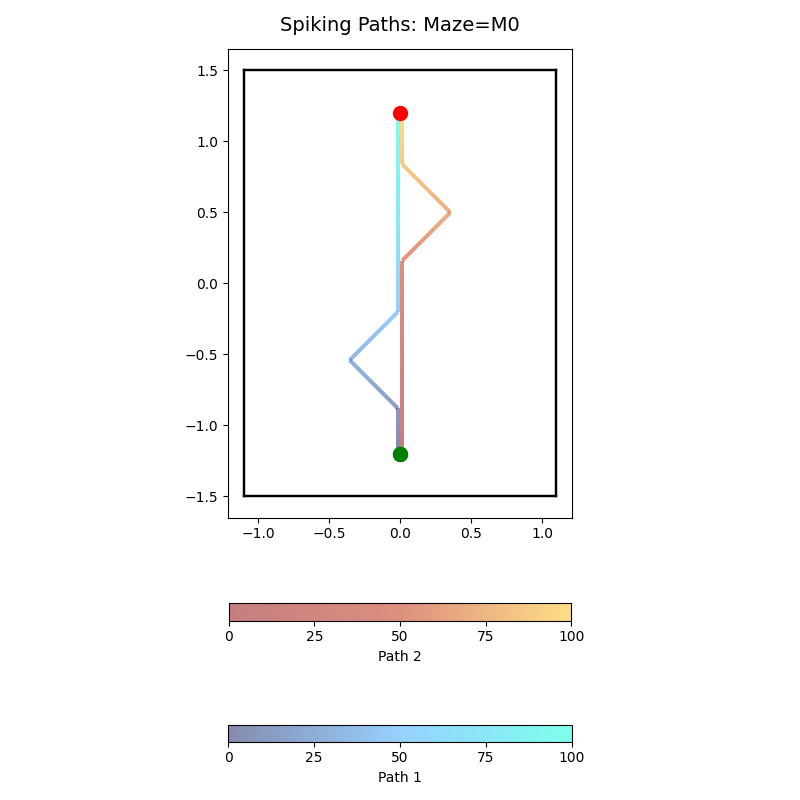

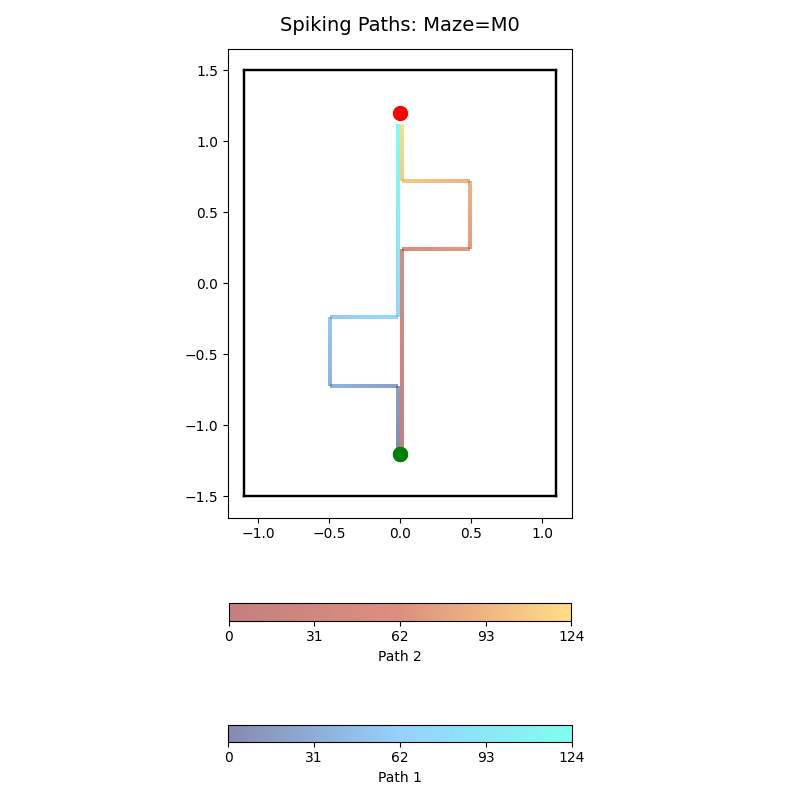

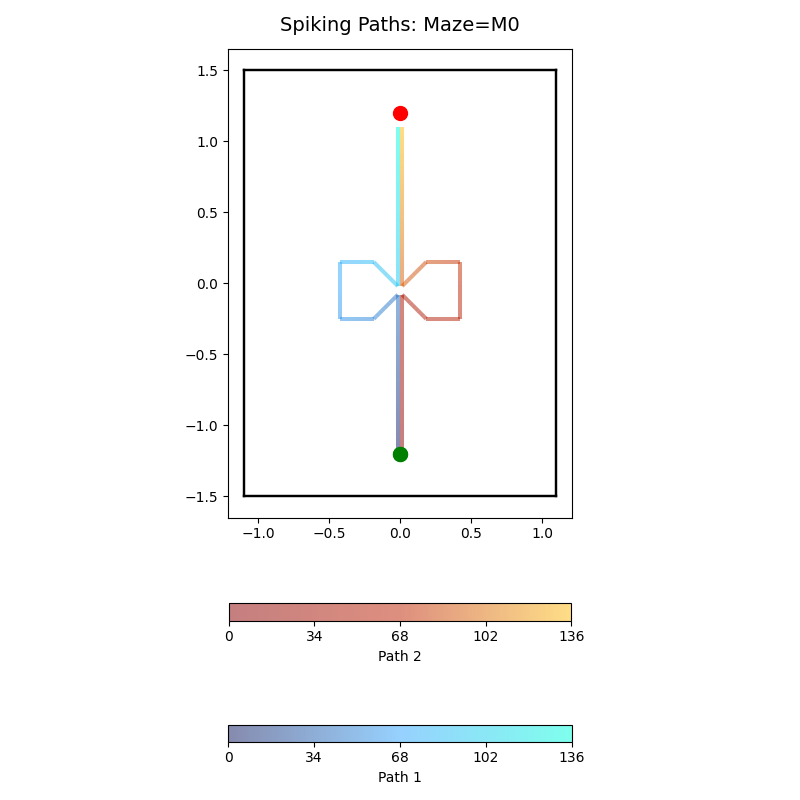

In [9]:
run_id = 0
test = summaries2[summaries2['rat']==run_id]
maze_folder, pcs_folder = getMazeAndPcsFolder()
counter = 0
for index, row in test.iterrows():
    fig1 = plot_replay_matrix_unseen(row,maze_folder,pcs_folder,run_id, replay_arrow_alpha =0, path_alpha=.5)
    fig1.savefig("PresentationFigs/UnseenPaths"+ str(counter) +".png",bbox_inches='tight')
    counter+=1

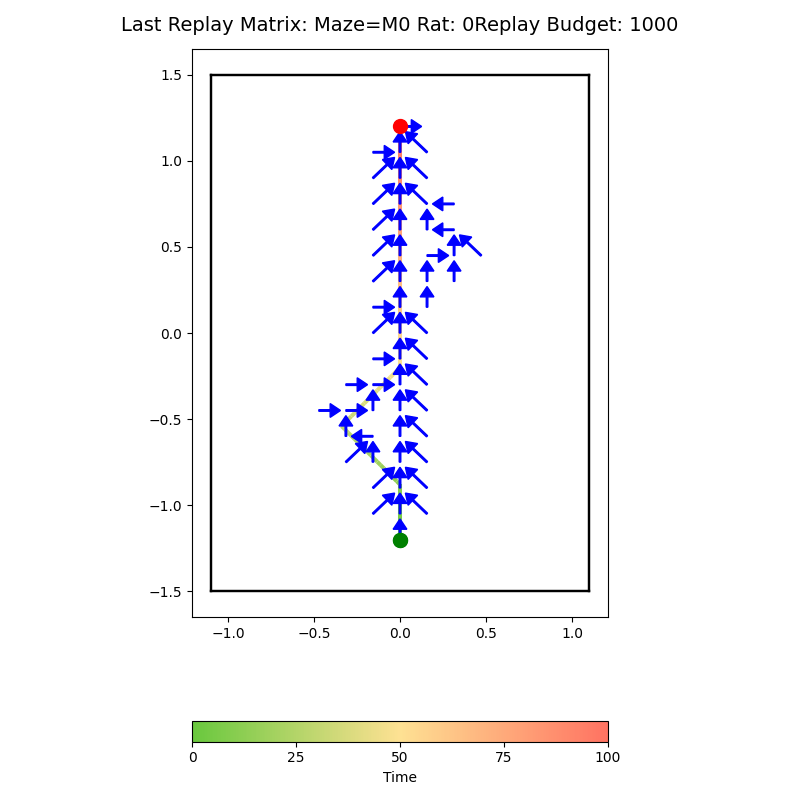

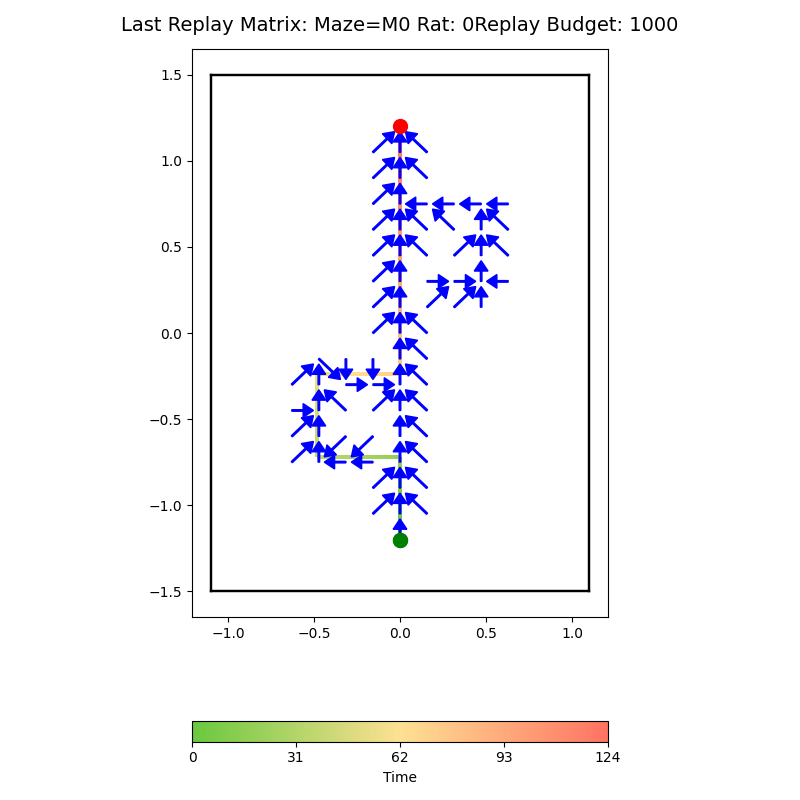

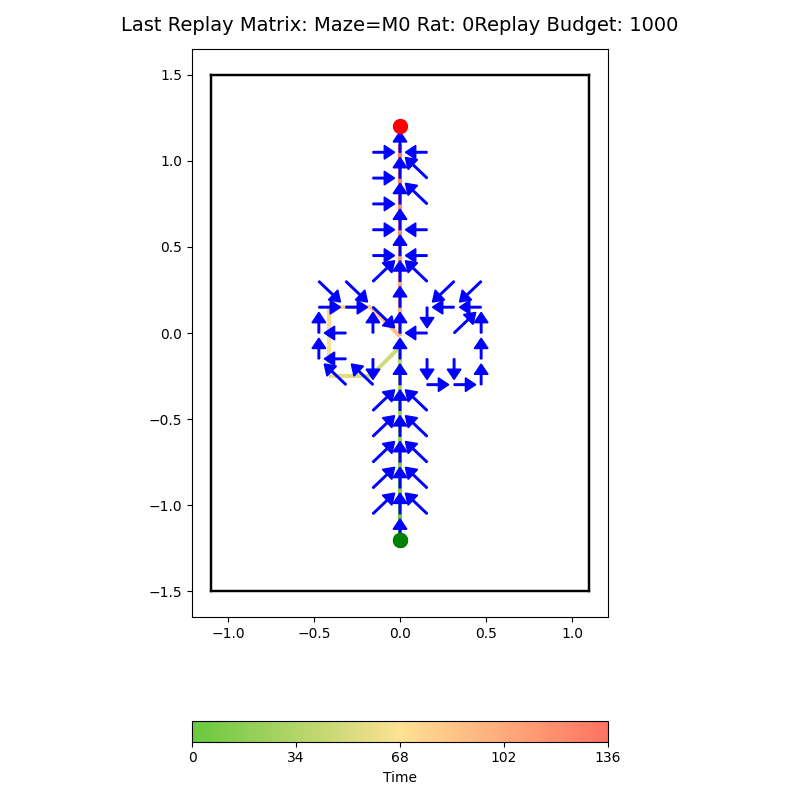

In [19]:
run_id = 0
test = summaries2[summaries2['rat']==run_id]
maze_folder, pcs_folder = getMazeAndPcsFolder()
counter = 0
for index, row in test.iterrows():
    fig2 = plot_replay_matrix(row,maze_folder,pcs_folder,run_id,run='last')
    fig2.savefig("PresentationFigs/LastReplayMatrix"+str(counter)+".png",bbox_inches='tight')
    counter +=1

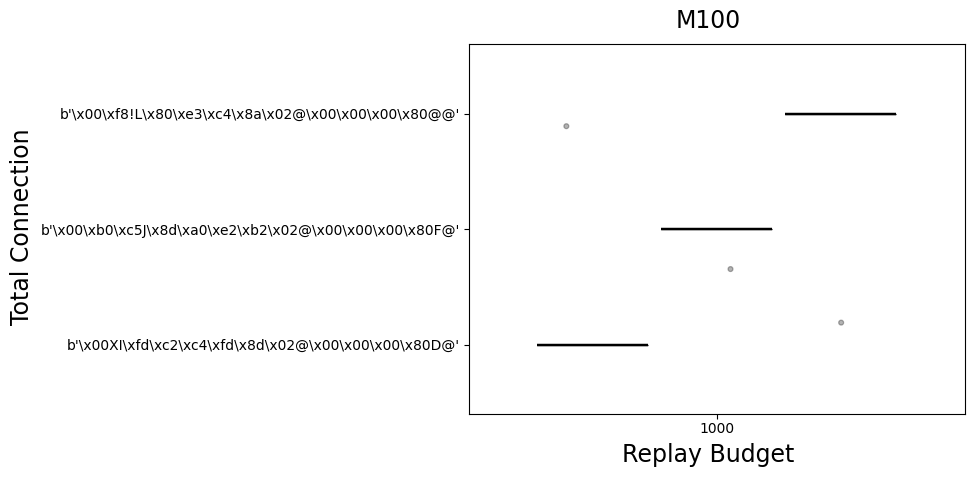

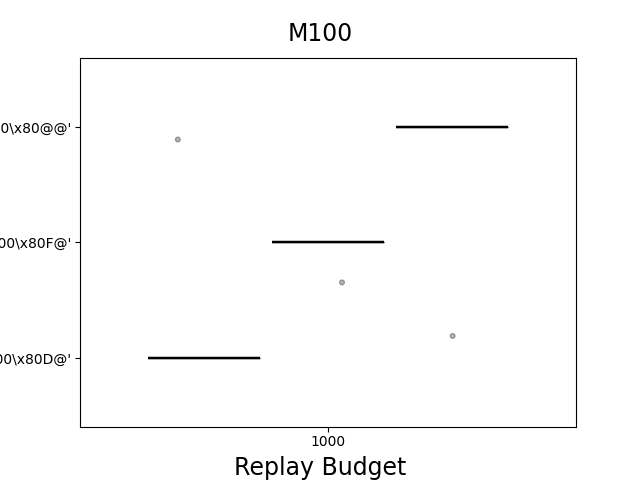

In [16]:
def plot_box_plot(data, x_column, y_column, x_title, y_title, plot_title, ylim, box_colors):
    # print(data)
    p0 = ggplot(data, aes(x_column, y_column ))
    p0 += geom_jitter(alpha=0.3)
    p0 += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0, color = box_colors )
    p0 += xlab(x_title)
    p0 += ylab(y_title)
    p0 += ggtitle(plot_title)
    # p0 += labs(x=x_title, y=y_title, title=plot_title)
    # p0 += theme(axis_text_x=element_text(rotation=45, hjust=1))
    # p0 += coord_cartesian(ylim=ylim)              
    return p0


def plot_time_series(data, x_column, y_column, fill_column, x_title, y_title, legend_title, plot_title, xlim, ylim):
    p0 = ggplot(data, aes(x_column, y_column, color=fill_column))
    
    p0 += geom_smooth(method='mavg')
    p0 += labs(x=x_title, y=y_title, color=legend_title, title=plot_title, caption='smt')
    # p0 += coord_cartesian(ylim=ylim, xlim=xlim)
    p0 += scale_color_discrete()
    return p0

# TODO: add plot for total connection metric
fig1 = plot_box_plot(learning_times, 'replay_budget_c', 'episode', 'Replay Budget', 'Episodes Optimal', 'M100', [0, 200], 'black' )

fig2 = plot_time_series(summaries, 'episode', 'steps', 'replay_budget_c', 'Episodes', 'Steps', 'Replay Budget', 'M100', [0,250], [0, 50] )

fig3 = plot_box_plot(summaries2, 'replay_budget_c', 'mean', 'Replay Budget', 'Average Connection', 'M100',[0, 200], 'black')

fig4 = plot_box_plot(summaries2, 'replay_budget_c', 'std', 'Replay Budget', 'STD Connection', 'M100',[0, 200], 'black')

fig5 = plot_box_plot(runtimes_last_episode, 'replay_budget_c', 'steps', 'Replay Budget', 'Optimality Ratio', 'Optimality Ratio M100',[0, 200], 'black')

test = summaries2[summaries2['replay_budget_c']!= 0]

fig6 = plot_box_plot(test, 'replay_budget_c', 'total_connection', 'Replay Budget', 'Total Connection', 'M100',[0, 200], 'black')

# fig1.draw()
# fig2.draw()
# fig3.draw()
# fig4.draw()
# fig5.draw()
fig6.draw()

In [10]:
fig3 = plot_box_plot(summaries, 'replay_budget_c', 'mean', 'Replay Budget', 'Average Connection', 'M100',[0, 200], 'black')

# Sandbox for SQL

In [11]:
import csv
def getLastMatrix(file, num_cells = 315):
    p = list(csv.reader(file, delimiter='\n'))
    start_index = len(p)-num_cells
    last_matrix = p[start_index:]
    print(len(last_matrix))

    for i in range(len(last_matrix)):
        last_matrix[i] = [r.strip() for r in last_matrix[i][0].split(',')]
        last_matrix[i] = last_matrix[i][:num_cells]
        last_matrix[i] = [float(r) for r in last_matrix[i]]
    return np.array(last_matrix,dtype=np.float128)
    
num_cells = 315
file_path = 'experiments/replayF2021_experiments/logs/experiment12-replay/configs/c0/r{}-Replay_Matrix.csv'
with open(file_path.format(0), 'rt') as file:
    getLastMatrix(file)
        
                

315
